In [18]:
##import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from textwrap import wrap
from PIL import Image
import os
import cv2
import string
from tqdm import tqdm
import nltk
from pickle import load, dump
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import re
import warnings
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import DenseNet201
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, Add, Concatenate, Reshape, concatenate, Bidirectional, LayerNormalization, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,  ReduceLROnPlateau

In [41]:
from nltk.corpus import stopwords
from keras.models import load_model
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import time

In [3]:
image_path = "C:/Users/AMAL/Documents/Image Captioning Dataset/Flickr_8k_Dataset/Images"

In [4]:
data = pd.read_csv("C:/Users/AMAL/Documents/Image Captioning Dataset/Flickr_8k_Dataset/captions.txt")
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [5]:
plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [6]:
#Converts a PIL Image instance to a Numpy array. 
#If you start from a PNG image, the values inside the image will lie between 0 and 255
#img_to_array however will cast to float. In your code example, the array is divided by 255, 
#so that's why you end up with floats between 0 and 1.
#This code is actually for reducing the range of values from 0-255 to 0-1
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)/255
    
    return img
#Reset the index, or a level of it. If the DataFrame has a MultiIndex, this method can remove one or more levels.
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"C:/Users/AMAL/Documents/Image Captioning Dataset/Flickr_8k_Dataset/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], width = 20)))
        plt.axis("off")

#we wrap the title to a specified width (in this case, 20 characters). 
#We then join the wrapped lines using the newline character (\n) 
#and set the wrapped title as the plot title.

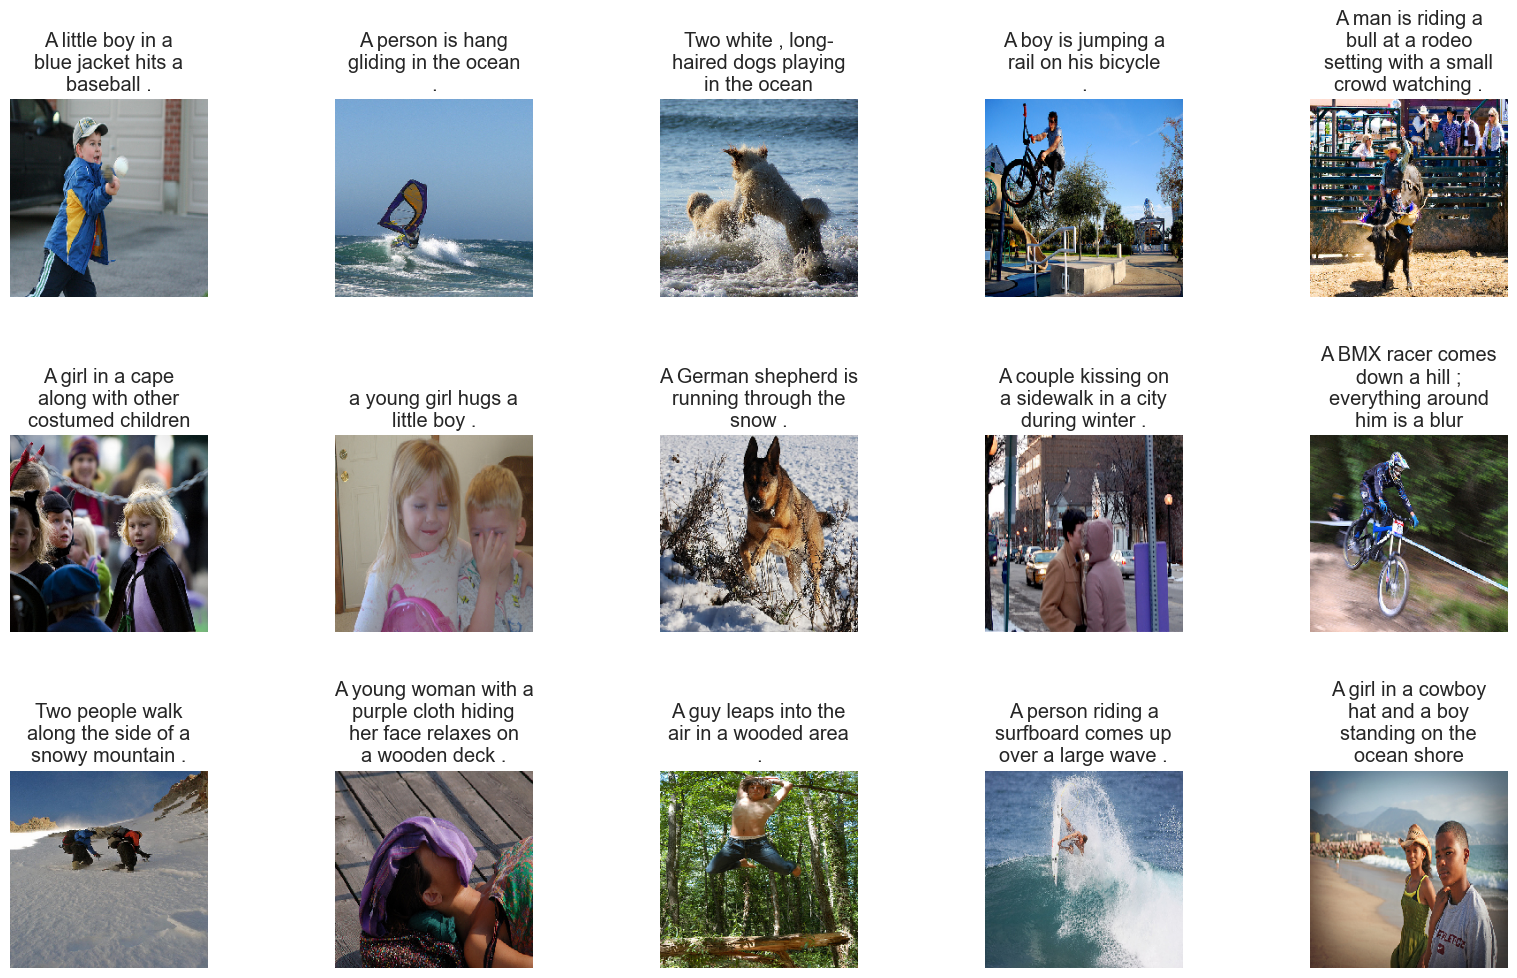

In [7]:
display_images(data.sample(15))

In [8]:
# Text preprocessing
## add start and end tags to the caption
# Load stopwords
# Convert to lower case
# Removing punctuation marks, removing numbers, and removing additional spaces.
def text_preprocessing(data):
    stop_words = set(stopwords.words('english'))

    def preprocess_caption(caption):
        caption = caption.lower()
        caption = re.sub(r"[^a-zA-Z]", " ", caption)
        caption = re.sub(r"\s+", " ", caption).strip()
        caption = " ".join([word for word in caption.split() if len(word) > 1 and word not in stop_words])
        return "startseq " + caption + " endseq"
    
    data['caption'] = data['caption'].apply(preprocess_caption)
    return data

In [9]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child pink dress climbing set stairs entry way endseq',
 'startseq girl going wooden building endseq',
 'startseq little girl climbing wooden playhouse endseq',
 'startseq little girl climbing stairs playhouse endseq',
 'startseq little girl pink dress going wooden cabin endseq',
 'startseq black dog spotted dog fighting endseq',
 'startseq black dog tri colored dog playing road endseq',
 'startseq black dog white dog brown spots staring street endseq',
 'startseq two dogs different breeds looking road endseq',
 'startseq two dogs pavement moving toward endseq']

In [10]:
# Prepare image feature extraction model
def preprocess_image(image_file, target_size=224):
    img = Image.open(os.path.join(image_path, image_file))
    # Resize the image maintaining the aspect ratio
    img.thumbnail((target_size, target_size))
    # Create a new image with a white background and centers the resized image on the new background
    new_img = Image.new("RGB", (target_size, target_size), (255, 255, 255))
    new_img.paste(img, ((target_size - img.width) // 2, (target_size - img.height) // 2))
     # Convert the image to a NumPy array and normalize the image data to the range [0, 1]
    img_array = img_to_array(new_img) / 255.0
    
    return np.expand_dims(img_array, axis=0)
    ##If your images are already clear, there's no need to apply Gaussian blu
    #img_array_blur = cv2.GaussianBlur(img_array, (3, 3), 0)


# Function to display preprocessed images
def check_preprocessed_images(image_files, num_images=5, target_size=224):
    plt.figure(figsize=(15, 15))
    for i, image_file in enumerate(image_files[:num_images]):
        preprocessed_image = preprocess_image(image_file, target_size)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(preprocessed_image[0])
        plt.axis('off')
    plt.show()

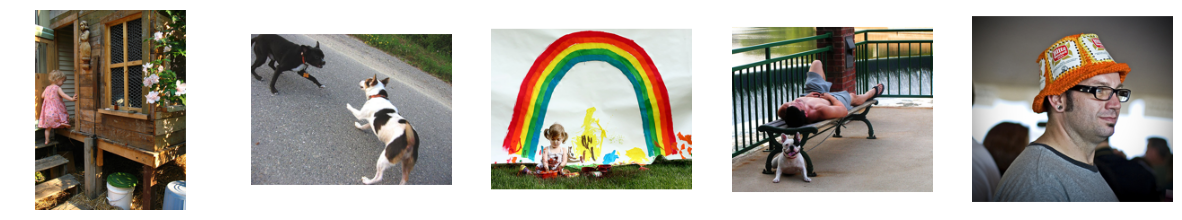

In [11]:
# Sample images to check preprocessing
sample_images = data['image'].unique().tolist()[:10]  # Take first 10 unique image filenames
check_preprocessed_images(sample_images, num_images=5)

In [11]:
# Get unique images
images = data['image'].unique().tolist()
nimages = len(images)

# Step 1: Split the data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

##splitting the dataset
images = data['image'].unique().tolist()
train_images, test_images = train_test_split(images, test_size=0.3, random_state=42)
val_images, test_images = train_test_split(test_images, test_size=0.67, random_state=42)  # 0.67 * 0.3 ≈ 0.2 of the total

train = data[data['image'].isin(train_images)]
val = data[data['image'].isin(val_images)]
test = data[data['image'].isin(test_images)]

train.reset_index(inplace=True, drop=True)
val.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)
tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

In [12]:
##feature extraction using DenseNet201 pretrained model
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████████████████████████████████████████████████████████████████████████| 8091/8091 [56:20<00:00,  2.39it/s]


In [13]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [24]:
##Model1
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [25]:
caption_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 1920)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 256)               │         491,776 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_6 (InputLayer)    │ (None, 34)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_1 (Reshape)           │ (None, 1, 256)            │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 34, 256)           │       2,172,160 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 35, 256)           │               0 │ reshape_1[0][0],           │
│                               │                           │                 │ embedding_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 256)               │         525,312 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256)               │               0 │ lstm_1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 256)               │               0 │ dropout[0][0],             │
│                               │                           │                 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 128)               │          32,896 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128)               │               0 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 8485)              │       1,094,565 │ dropout_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 4,316,709 (16.47 MB)

 Trainable params: 4,316,709 (16.47 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
#Create Data Generators
train_generator = CustomDataGenerator(df=train, X_col='image', y_col='caption', batch_size=64, directory=image_path,
                                      tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)

validation_generator = CustomDataGenerator(df=val, X_col='image', y_col='caption', batch_size=64, directory=image_path,
                                           tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)

test_generator = CustomDataGenerator(df=test, X_col='image', y_col='caption', batch_size=64, directory=image_path,
                                     tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)


In [28]:
# Define checkpoint callback
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [29]:
history = caption_model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/20


C:\Users\AMAL\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 5.6905
Epoch 1: val_loss improved from inf to 4.18593, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 2191s 4s/step - loss: 5.6893 - val_loss: 4.1859 - learning_rate: 0.0010
Epoch 2/20
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 764ms/step - loss: 4.2168
Epoch 2: val_loss improved from 4.18593 to 3.90046, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 441s 820ms/step - loss: 4.2167 - val_loss: 3.9005 - learning_rate: 0.0010
Epoch 3/20
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 751ms/step - loss: 3.9283
Epoch 3: val_loss improved from 3.90046 to 3.77024, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 434s 806ms/step - loss: 3.9282 - val_loss: 3.7702 - learning_rate: 0.0010
Epoch 4/20
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - loss: 3.7582
Epoch 4: val_loss improved from 3.77024 to 3.70399, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 436s 811ms/step - loss: 3.7582 - val_loss: 3.7040 - learning_rate: 0.0010
Epoch 5/20
5

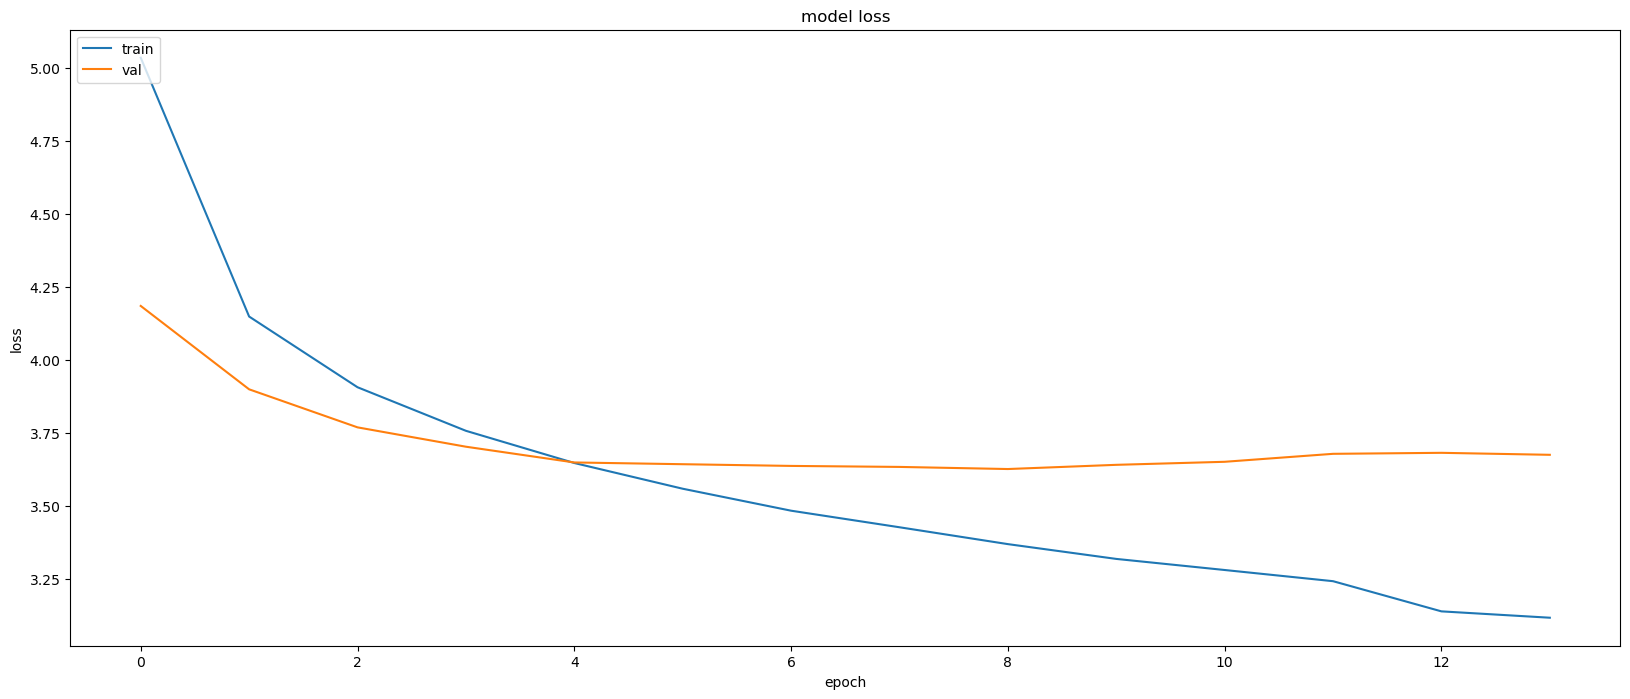

In [30]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
##
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [32]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

In [33]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [34]:
samples.head()

image  \
0  3723903586_e98d3d8ec7.jpg   
1  3732728142_86364a706e.jpg   
2   482088914_e6ea4501e9.jpg   
3   979201222_75b6456d34.jpg   
4   515797344_4ae75cb9b1.jpg   

                                             caption  
0  startseq greyhound race with the lead dog wear...  
1  startseq baby with red hat sits in his strolle...  
2  startseq person in blue kayak battles the wave...  
3  startseq two girls are walking away from the c...  
4  startseq three men cross the street in front o...

In [35]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

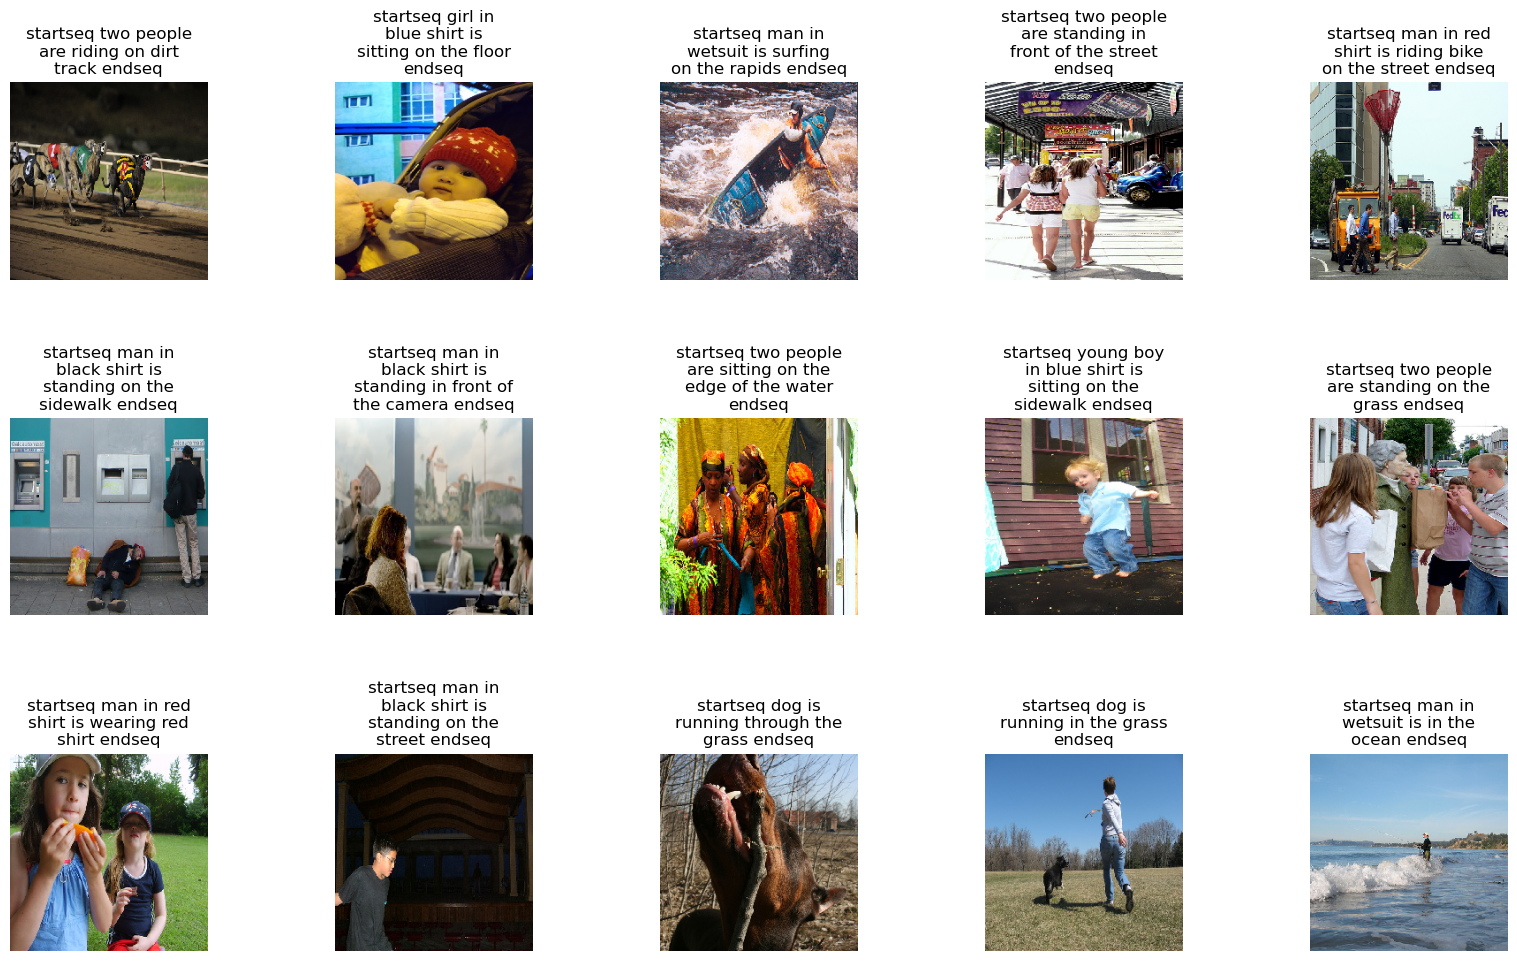

In [36]:
display_images(samples)

In [49]:
##model2


In [22]:
# Input layers
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

# Image features processing
img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256))(img_features)

# Sentence features processing
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped, sentence_features], axis=1)
sentence_features = LSTM(256)(merged)

# Combining features
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

# Model definition
caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

# Model summary
caption_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 1920)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 256)               │         491,776 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_4 (InputLayer)    │ (None, 23)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_1 (Reshape)           │ (None, 1, 256)            │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 23, 256)           │       2,128,896 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 24, 256)           │               0 │ reshape_1[0][0],           │
│                               │                           │                 │ embedding_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 256)               │         525,312 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 256)               │               0 │ lstm_1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 256)               │               0 │ dropout_1[0][0],           │
│                               │                           │                 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 128)               │          32,896 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 128)               │               0 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 8316)              │       1,072,764 │ dropout_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 4,251,644 (16.22 MB)

 Trainable params: 4,251,644 (16.22 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:

# Step 7: Train the Model
history = caption_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction]
)

Epoch 1/20


C:\Users\AMAL\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 5.7817
Epoch 1: val_loss did not improve from 3.62755
442/442 ━━━━━━━━━━━━━━━━━━━━ 1846s 4s/step - loss: 5.7803 - val_loss: 4.3808 - learning_rate: 0.0010
Epoch 2/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - loss: 4.3163
Epoch 2: val_loss did not improve from 3.62755
442/442 ━━━━━━━━━━━━━━━━━━━━ 383s 866ms/step - loss: 4.3162 - val_loss: 4.0567 - learning_rate: 0.0010
Epoch 3/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - loss: 4.0113
Epoch 3: val_loss did not improve from 3.62755
442/442 ━━━━━━━━━━━━━━━━━━━━ 365s 825ms/step - loss: 4.0113 - val_loss: 3.9309 - learning_rate: 0.0010
Epoch 4/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - loss: 3.8345
Epoch 4: val_loss did not improve from 3.62755
442/442 ━━━━━━━━━━━━━━━━━━━━ 363s 820ms/step - loss: 3.8345 - val_loss: 3.8679 - learning_rate: 0.0010
Epoch 5/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - loss: 3.7076
Epoch 5: val_loss did not improve from 3.62755
442/442 ━━━━━━━━━━━━━━━━

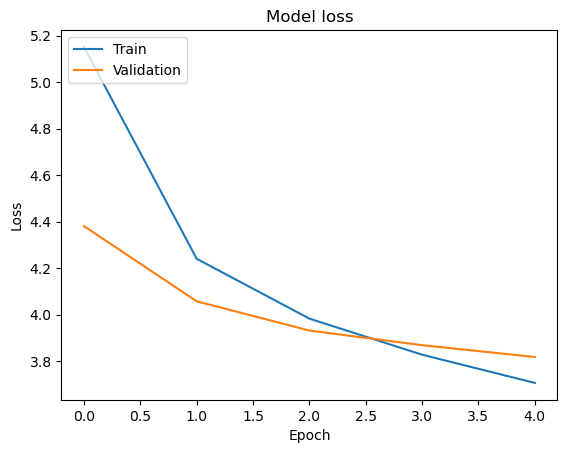

In [50]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [85]:
# Assuming you saved the best model using ModelCheckpoint
best_model_path = 'model.keras'
best_model = tf.keras.models.load_model(best_model_path)


In [78]:
# Evaluate the model on test data
evaluation = best_model.evaluate(test_generator)

# Print the evaluation results (typically loss)
print("Test Loss:", evaluation)


126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 324ms/step - loss: 2.9996
Test Loss: 3.001096248626709


In [79]:
def predict_captions(model, image, tokenizer, max_length, features):
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        y_pred = model.predict([feature, sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None or word == 'endseq':
            break
            
        in_text += " " + word
    
    return in_text.strip()


In [82]:
###samples = test.sample(15)
##samples.reset_index(drop=True,inplace=True)

In [90]:
data.tail(10)

image  \
40445  997338199_7343367d7f.jpg   
40446  997338199_7343367d7f.jpg   
40447  997338199_7343367d7f.jpg   
40448  997338199_7343367d7f.jpg   
40449  997338199_7343367d7f.jpg   
40450  997722733_0cb5439472.jpg   
40451  997722733_0cb5439472.jpg   
40452  997722733_0cb5439472.jpg   
40453  997722733_0cb5439472.jpg   
40454  997722733_0cb5439472.jpg   

                                                 caption  
40445  startseq startseq person stands near golden wa...  
40446  startseq startseq woman behind scrolled wall i...  
40447  startseq startseq woman standing near decorate...  
40448  startseq startseq the walls are covered in gol...  
40449  startseq startseq woman writing on pad in room...  
40450  startseq startseq man in pink shirt climbs roc...  
40451  startseq startseq man is rock climbing high in...  
40452  startseq startseq person in red shirt climbing...  
40453  startseq startseq rock climber in red shirt en...  
40454  startseq startseq rock climber practices on ro...

In [91]:

# Example usage to generate predictions for a single image
image_file = '997722733_0cb5439472.jpg'
predicted_caption = predict_captions(best_model, image_file, tokenizer, max_length, features)
print("Predicted Caption:", predicted_caption)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Caption: startseq man in red shirt is climbing rock wall


In [41]:
## create function to convert an integer back to its corresponding word using the tokenizer's word index dictionary. 
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
##function to predict caption
def predict_caption(model, image, tokenizer, max_length, features):
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        y_pred = model.predict([feature, sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None or word == 'endseq':
            break
            
        in_text += " " + word
    
    return in_text.strip()

# Generate predictions for the test set
predictions = []
references = []
for index, row in test.iterrows():
    image_file = row['image']
    predicted_caption = predict_caption(best_model, image_file, tokenizer, max_length, features)
    predictions.append(predicted_caption.split())
    references.append([row['caption'].split()])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

In [94]:
print("Number of references:", len(references))
print("Number of predictions:", len(predictions))


Number of references: 4235
Number of predictions: 4235


In [103]:
def calculate_bleu(references, predictions):
    smoothie = SmoothingFunction().method4
    bleu_scores = []
    
    for ref, pred in zip(references, predictions):
        start_time = time.time()
        score = sentence_bleu(ref, pred, smoothing_function=smoothie)
        bleu_scores.append(score)
        end_time = time.time()
        print(f"Processed one pair in {end_time - start_time} seconds")
    
    return np.mean(bleu_scores)

In [114]:
sample_size = 40000  # or any small number
references_sample = references[:sample_size]
predictions_sample = predictions[:sample_size]

# Calculate BLEU score
bleu_score = calculate_bleu(references_sample, predictions_sample)
print("BLEU Score:", bleu_score)

Processed one pair in 0.000997304916381836 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.000997304916381836 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.000997781753540039 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0009970664978027344 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Reference: startseq two sumo wrestlers are fighting in ring endseq
Predicted: startseq two boys playing in the water


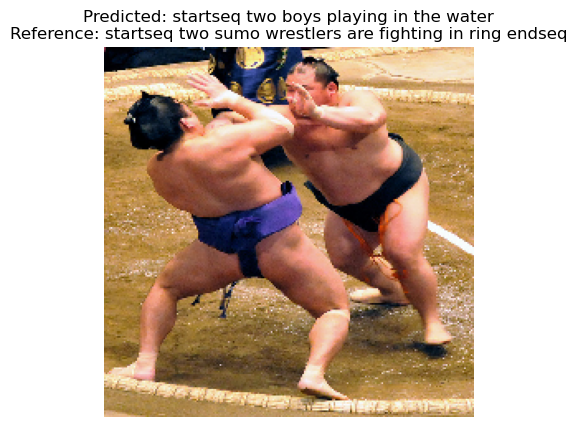

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Reference: startseq several players playing game of hockey outside on the road endseq
Predicted: startseq two men are playing in the grass


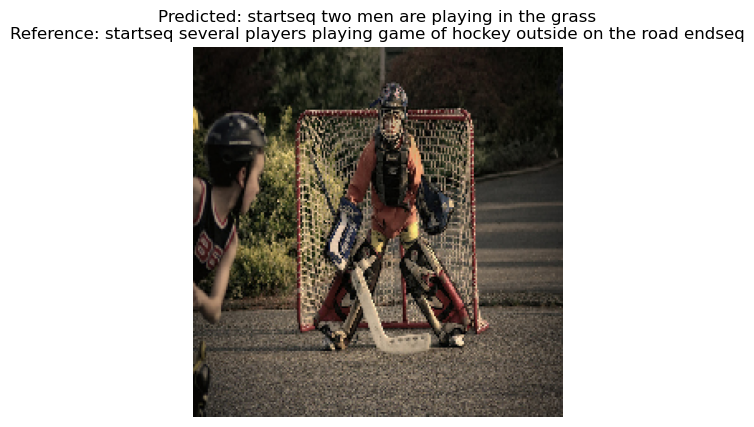

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Reference: startseq people in red and pink walking down large steps endseq
Predicted: startseq man in red shirt is standing on the steps


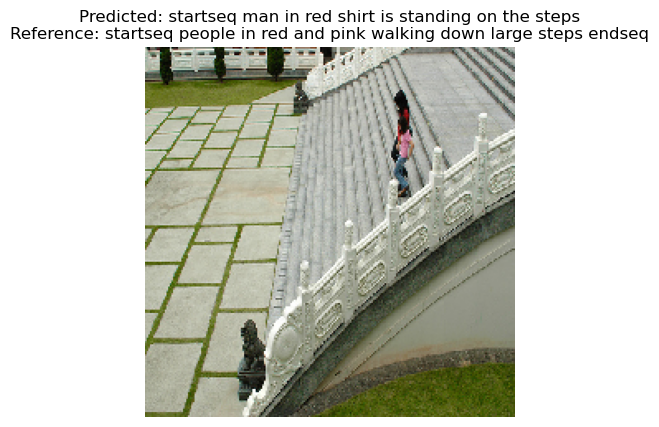

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Reference: startseq the fat brown dog is standing over the little white dog endseq
Predicted: startseq two dogs are playing in the grass


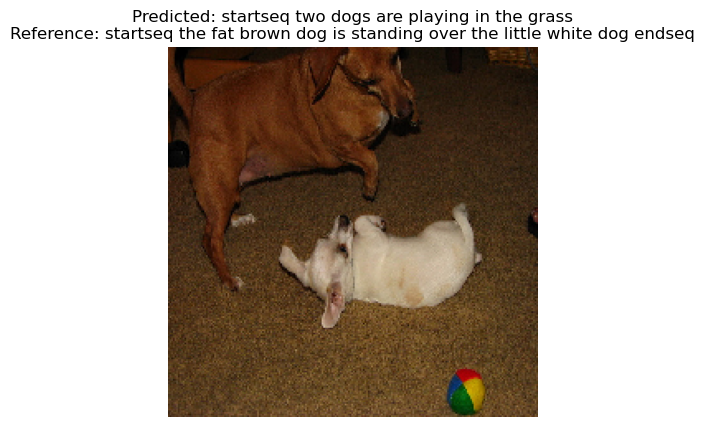

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Reference: startseq three dogs are playing outside with tennis ball endseq
Predicted: startseq two dogs are running through the grass


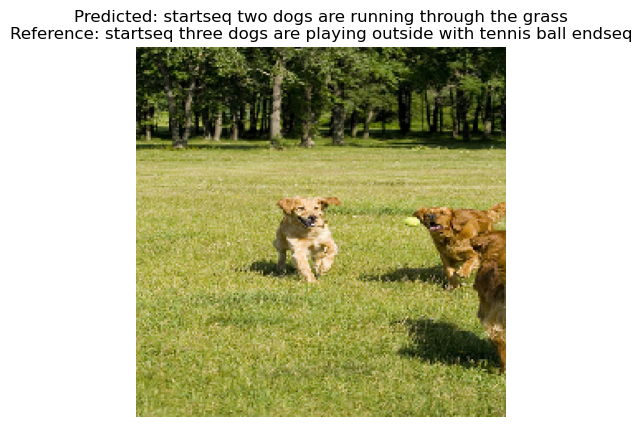

In [115]:
samples = test.sample(5)
samples.reset_index(drop=True, inplace=True)

for index, record in samples.iterrows():
    img = load_img(os.path.join(image_path, record['image']), target_size=(224, 224))
    img = img_to_array(img) / 255.
    caption = predict_caption(best_model, record['image'], tokenizer, max_length, features)
    print(f"Reference: {record['caption']}")
    print(f"Predicted: {caption}")
    
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {caption}\nReference: {record['caption']}")
    plt.show()

In [50]:
##model3

In [15]:
def build_model(vocab_size, max_length, learning_rate):
    optimizer = Adam(learning_rate=learning_rate)
    
    # Input layers
    input1 = Input(shape=(1920,))
    input2 = Input(shape=(max_length,))
    
    # Image features processing
    img_features = Dense(256, activation='relu')(input1)
    img_features_reshaped = Reshape((1, 256))(img_features)
    
    # Sentence features processing
    sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
    merged = concatenate([img_features_reshaped, sentence_features], axis=1)
    
    # LSTM Layer
    sentence_features = LSTM(256)(merged)
    
    # Combining features
    x = Dropout(0.5)(sentence_features)
    x = Add()([x, img_features])
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(vocab_size, activation='softmax')(x)
    
    # Model definition
    caption_model = Model(inputs=[input1, input2], outputs=output)
    caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer)
    
    return caption_model

# Mixed precision training
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

In [19]:
learning_rates = [0.001, 0.0001]
batch_sizes = [16, 32]  # Reduced batch size for faster testing
best_bleu_score = 0
best_model = None

for lr in learning_rates:
    for bs in batch_sizes:
        print(f"Training with learning rate {lr} and batch size {bs}")
        model = build_model(vocab_size, max_length, lr)
        
        train_generator = CustomDataGenerator(df=train, X_col='image', y_col='caption', batch_size=bs, directory=image_path,
                                              tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)

        validation_generator = CustomDataGenerator(df=val, X_col='image', y_col='caption', batch_size=bs, directory=image_path,
                                                   tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)


        # Train the model
        history = model.fit(
            train_generator,
            epochs=10,  # Reduced epochs for testing
            validation_data=validation_generator,
            callbacks=[checkpoint, earlystopping, learning_rate_reduction]
        )

Training with learning rate 0.001 and batch size 16
Epoch 1/10
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 1373s 774ms/step - loss: 5.8702 - val_loss: 4.7978 - learning_rate: 0.0010
Epoch 2/10
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 843s 477ms/step - loss: 4.6943 - val_loss: 4.5582 - learning_rate: 0.0010
Epoch 3/10
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 491s 277ms/step - loss: 4.4285 - val_loss: 4.4795 - learning_rate: 0.0010
Epoch 4/10
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 484s 274ms/step - loss: 4.2507 - val_loss: 4.4373 - learning_rate: 0.0010
Epoch 5/10
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 482s 272ms/step - loss: 4.1164 - val_loss: 4.4381 - learning_rate: 0.0010
Epoch 6/10
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 28908s 16s/step - loss: 4.0391 - val_loss: 4.4556 - learning_rate: 0.0010
Epoch 7/10
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 493s 278ms/step - loss: 3.9172 - val_loss: 4.4177 - learning_rate: 1.0000e-04
Epoch 8/10
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 493s 279ms/step - loss: 3.8692 - val_loss: 4.4278 - learning_rate: 1.0000e-04
Epoch 9/10


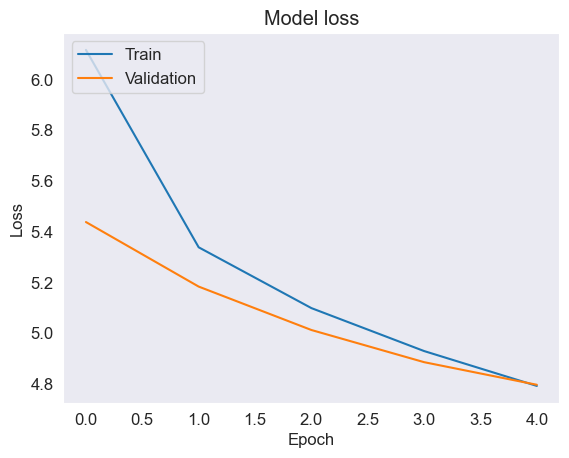

In [32]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [31]:
# Assuming you saved the best model using ModelCheckpoint
best_model_path = 'model.keras'
best_model = tf.keras.models.load_model(best_model_path)
# Evaluate the model on test data
evaluation = best_model.evaluate(test_generator)
     
# Pri nt the evaluation results (typically loss)
print("Test Loss:", evaluation)

127/127 ━━━━━━━━━━━━━━━━━━━━ 35s 270ms/step - loss: 4.3556
Test Loss: 4.346541881561279


In [33]:
def predict_captions(model, image, tokenizer, max_length, features):
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        y_pred = model.predict([feature, sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None or word == 'endseq':
            break
            
        in_text += " " + word
    
    return in_text.strip()

In [34]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [35]:
# Example usage to generate predictions for a single image
image_file = '997722733_0cb5439472.jpg'
predicted_caption = predict_captions(best_model, image_file, tokenizer, max_length, features)
print("Predicted Caption:", predicted_caption)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Caption: startseq man wearing blue shirt jumping water


In [36]:
def predict_caption(model, image, tokenizer, max_length, features):
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        y_pred = model.predict([feature, sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None or word == 'endseq':
            break
            
        in_text += " " + word
    
    return in_text.strip()

# Generate predictions for the test set
predictions = []
references = []
for index, row in test.iterrows():
    image_file = row['image']
    predicted_caption = predict_caption(best_model, image_file, tokenizer, max_length, features)
    predictions.append(predicted_caption.split())
    references.append([row['caption'].split()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

In [37]:
print("Number of references:", len(references))
print("Number of predictions:", len(predictions))


Number of references: 1210
Number of predictions: 1210


In [39]:
def calculate_bleu(references, predictions):
    smoothie = SmoothingFunction().method4
    bleu_scores = []
    
    for ref, pred in zip(references, predictions):
        start_time = time.time()
        score = sentence_bleu(ref, pred, smoothing_function=smoothie)
        bleu_scores.append(score)
        end_time = time.time()
        print(f"Processed one pair in {end_time - start_time} seconds")
    
    return np.mean(bleu_scores)

In [42]:
sample_size = 40000  # or any small number
references_sample = references[:sample_size]
predictions_sample = predictions[:sample_size]

# Calculate BLEU score
bleu_score = calculate_bleu(references_sample, predictions_sample)
print("BLEU Score:", bleu_score)

Processed one pair in 0.000997304916381836 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0009970664978027344 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0009982585906982422 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 seconds
Processed one pair in 0.0 sec

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Reference: startseq man rides bicycle dirt ramp endseq
Predicted: startseq man jumping air


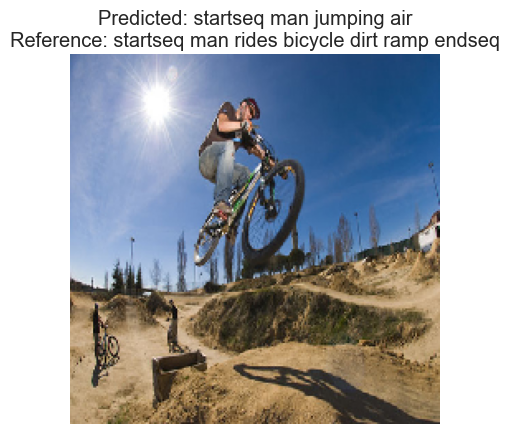

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Reference: startseq two child share swing playground endseq
Predicted: startseq girl swinging swing


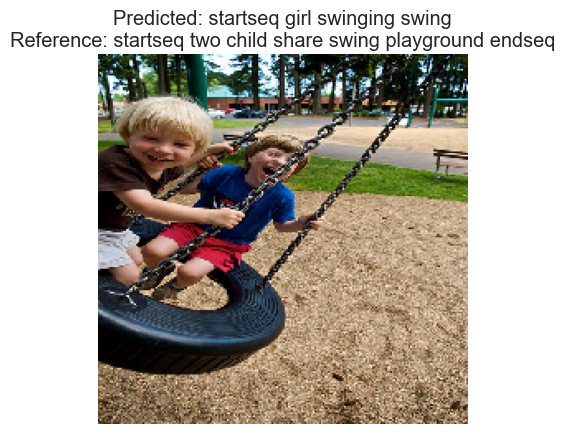

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Reference: startseq young girl dressed black swings around rope red ball end endseq
Predicted: startseq boy wearing blue shirt jumping


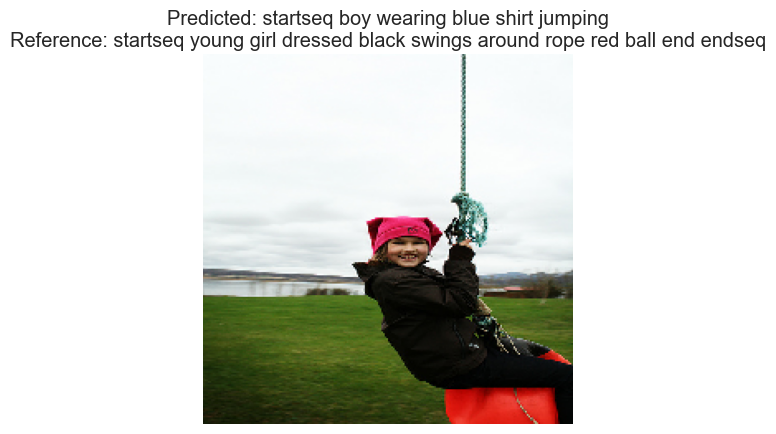

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Reference: startseq black white dog running outdoors endseq
Predicted: startseq black dog running grass


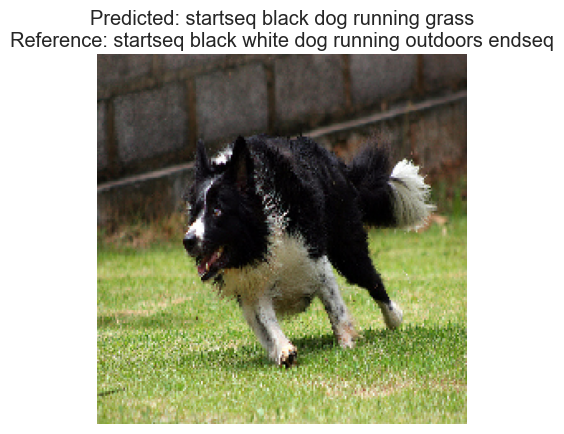

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Reference: startseq man dressed camouflage riding motorbike endseq
Predicted: startseq man riding bike


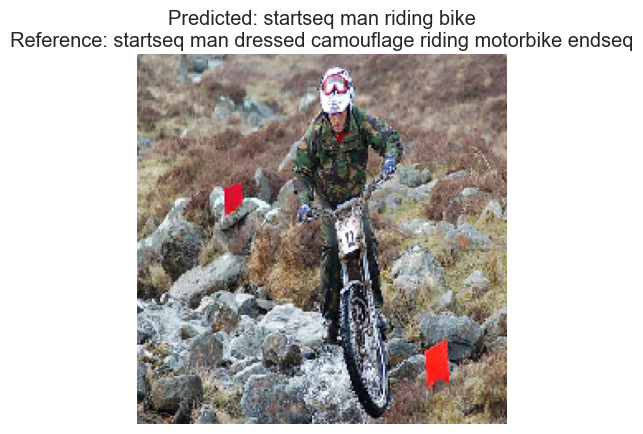

In [43]:
samples = test.sample(5)
samples.reset_index(drop=True, inplace=True)

for index, record in samples.iterrows():
    img = load_img(os.path.join(image_path, record['image']), target_size=(224, 224))
    img = img_to_array(img) / 255.
    caption = predict_caption(best_model, record['image'], tokenizer, max_length, features)
    print(f"Reference: {record['caption']}")
    print(f"Predicted: {caption}")
    
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {caption}\nReference: {record['caption']}")
    plt.show()